Import data

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Input, Dense, LSTM, Dropout, concatenate, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from keras.models import Model
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error


Enable GPU

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPu not found")
  #raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
'''tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)'''

'tpu = tf.distribute.cluster_resolver.TPUClusterResolver()\ntf.config.experimental_connect_to_cluster(tpu)\ntf.tpu.experimental.initialize_tpu_system(tpu)\nstrategy = tf.distribute.experimental.TPUStrategy(tpu)'

Preprocess data

In [4]:
mb_raw_data = pd.read_csv('/kaggle/input/mann-bruker/mann_bruker.txt', sep='\t')
mb_clean_frame = mb_raw_data[['Modified sequence', 'm/z', 'CCS','Mass','Charge','Length']]
mb_clean_frame = mb_clean_frame.groupby(['Modified sequence', 'Charge']).agg({'Mass':'median', 'CCS':'median','Length':'median'}).reset_index()
del mb_raw_data
mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])

ccs_mean = mb_clean_frame['CCS'].mean()
ccs_std = mb_clean_frame['CCS'].std()
encode_length = 52

mb_clean_frame = mb_clean_frame.sample(frac=1, random_state=1)

*Define* One Hot Encoder

In [5]:
def normalize(seq):
    seq = seq.replace('_', '')
    seq = seq.replace('(ac)', 'a')
    seq = seq.replace('M(ox)', 'm')
    return seq

    
def one_hot_encode(seq):
    amino_acids = ['A', 'a', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'm', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'U', 'X']

    mapping = dict(zip(amino_acids, range(len(amino_acids))))

    seq2 = [mapping[i] for i in seq]

    return np.eye(len(amino_acids))[seq2]

In [6]:
print(normalize('_(ac)AASTSM(ox)VPVAVTAAVAPVLSINSDFSDLR_'))

aAASTSmVPVAVTAAVAPVLSINSDFSDLR


Do one Hot

In [7]:
# B = acetyl n-term, O Oxidation (M)
amino_acids = ['A', 'a', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'm', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'U', 'X']
mb_clean_frame['Modified sequence normalized'] = mb_clean_frame['Modified sequence'].apply(normalize)
sequences = mb_clean_frame['Modified sequence normalized']


sequences = [list(seq[:encode_length].ljust(encode_length, 'X')) for seq in sequences]

one_hot_sequences = [one_hot_encode(seq) for seq in tqdm(sequences)]


mass_charge_length = mb_clean_frame[['Mass', 'Charge','Length']].values


scaler = StandardScaler()
mass_charge_length_scaled = scaler.fit_transform(mass_charge_length)

y = mb_clean_frame['CCS_z'].values


100%|██████████| 236658/236658 [00:07<00:00, 32792.47it/s]


In [8]:
mb_clean_frame['Modified sequence normalized']

39975                EDYASGSGDK
106393                  KPGTHKK
127329    LQISTPDIKDNIVAQLKQLYR
207003        TPGLTSTESFVEAALLK
192254                  SLWKANR
                  ...          
229119            WTSQHSNTQTLGK
5192                   AEREQDPR
208780                  TSGNSAK
229611              YAIIIRKIPIK
128037               LQSQLLSLEK
Name: Modified sequence normalized, Length: 236658, dtype: object

Train Model

In [ ]:
X_train_seq, X_test_seq, X_train_mc, X_test_mc, y_train, y_test = train_test_split(one_hot_sequences, mass_charge_length_scaled, y, test_size=0.1, random_state=42)

sequence_input = Input(shape=(None, len(amino_acids)), name="sequence_input")
mass_charge_input = Input(shape=(3,), name="mass_charge_input")


sequence_branch = Bidirectional(LSTM(512, activation='tanh', return_sequences=True))(sequence_input)
sequence_branch = Dropout(0.2)(sequence_branch)
sequence_branch = Bidirectional(LSTM(512, activation='tanh', return_sequences=True))(sequence_branch)
sequence_branch = Dropout(0.2)(sequence_branch)
sequence_branch = Bidirectional(LSTM(256, activation='tanh'))(sequence_branch)


mass_charge_branch = Dense(16, activation="relu")(mass_charge_input)
mass_charge_branch = Dropout(0.2)(mass_charge_branch)
mass_charge_branch = Dense(8, activation="relu")(mass_charge_branch)

combined = concatenate([sequence_branch, mass_charge_branch])

z = Dense(128, activation="relu")(combined)
z = Dropout(0.2)(z)
z = Dense(64, activation="relu")(z)
z = Dropout(0.2)(z)
z = Dense(32, activation="relu")(z)
output = Dense(1, activation="linear", name="output")(z)


model = Model(inputs=[sequence_input, mass_charge_input], outputs=output)


optimizer = Adam()
model.compile(optimizer=optimizer, loss='huber', metrics=['mse'])

patience = 15
batch_size = 32
epochs = 100
checkpoint = ModelCheckpoint('LSTM_best_checkpoint.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
progress_bar = ProgbarLogger(count_mode='steps', stateful_metrics=None)


history = model.fit([np.array(X_train_seq), np.array(X_train_mc)], np.array(y_train), validation_data=([np.array(X_test_seq), np.array(X_test_mc)], np.array(y_test)), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint, early_stopping, progress_bar], verbose=1)
# Plotting loss during training and validation


Epoch 1/100
6656/6656 [==============================] - ETA: 0s - loss: 0.0163 - mse: 0.0335
Epoch 1: val_loss improved from inf to 0.01705, saving model to LSTM_best_checkpoint.keras
6656/6656 [==============================] - 359s 52ms/step - loss: 0.0163 - mse: 0.0335 - val_loss: 0.0171 - val_mse: 0.0342
Epoch 2/100
6656/6656 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0137
Epoch 2: val_loss improved from 0.01705 to 0.00714, saving model to LSTM_best_checkpoint.keras
6656/6656 [==============================] - 342s 51ms/step - loss: 0.0068 - mse: 0.0137 - val_loss: 0.0071 - val_mse: 0.0143
Epoch 3/100
6656/6656 [==============================] - ETA: 0s - loss: 0.0061 - mse: 0.0122
Epoch 3: val_loss did not improve from 0.00714
6656/6656 [==============================] - 343s 51ms/step - loss: 0.0061 - mse: 0.0122 - val_loss: 0.0093 - val_mse: 0.0186
Epoch 4/100
6655/6656 [============================>.] - ETA: 0s - loss: 0.0058 - mse: 0.0116
Epoch 4: val_

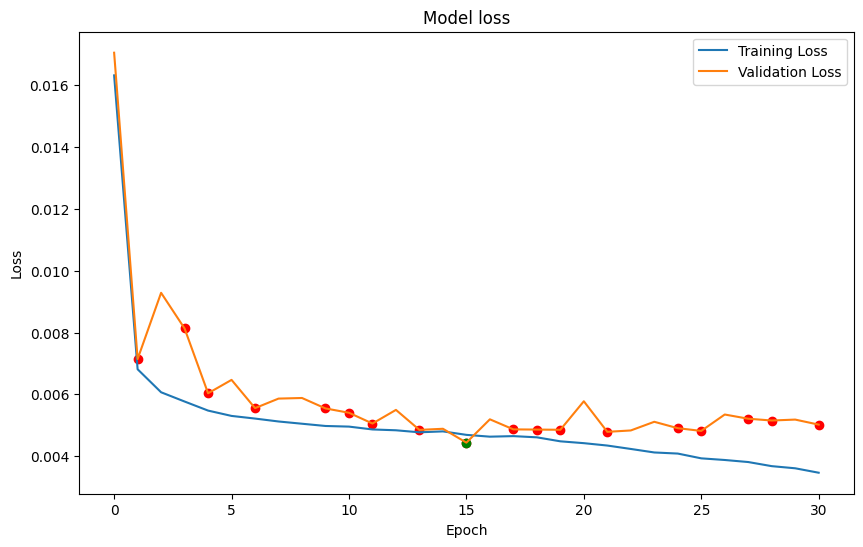

In [34]:

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Find epochs where the validation loss decreased
min_val_loss_epochs = np.where(np.diff(validation_loss) < 0)[0] + 1

# Find epoch where the validation loss is minimum
best_val_loss_epoch = np.argmin(validation_loss)

plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')

# Add a red dot
plt.scatter(min_val_loss_epochs, [validation_loss[i] for i in min_val_loss_epochs], color='red')

# Add a green dot
plt.scatter(best_val_loss_epoch, validation_loss[best_val_loss_epoch], color='green')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [35]:

hist_df = pd.DataFrame(history.history)

# Save to json
hist_json_file = 'history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)


Save the model and params

In [36]:
# Save the model
model.save('CCS_BiLSTM_modifications_52_length.keras')
with open('model_params.pkl', 'wb') as f:
    pickle.dump({'mean': ccs_mean, 'std': ccs_std, 'scaler': scaler}, f)

In [37]:
y_pred_test = model.predict([np.array(X_test_seq), np.array(X_test_mc)])
y_pred_test_orig = y_pred_test * ccs_std + ccs_mean
y_test_orig = y_test * ccs_std + ccs_mean

740/740 [==============================] - 14s 20ms/step


In [38]:
r2_test = r2_score(y_test_orig , y_pred_test_orig)
print(f"Test R^2: {r2_test}")

mse_test = mean_squared_error(y_test_orig , y_pred_test_orig)
print(f"Test MSE: {mse_test}")


Test R^2: 0.9899607992055204
Test MSE: 6.670285613123366e-73


In [39]:
from sklearn.metrics import median_absolute_error

absolute_errors = np.abs(y_pred_test_orig - y_test_orig)

mae = median_absolute_error(y_test_orig, y_pred_test_orig)

mre = mae / np.median(y_test_orig)

print(f"Test MRE: {mre}")


Test MRE: 0.014763705371156908


/tmp/ipykernel_32/3158844750.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test_orig, y_pred_test_orig, cmap='winter', alpha=0.2)


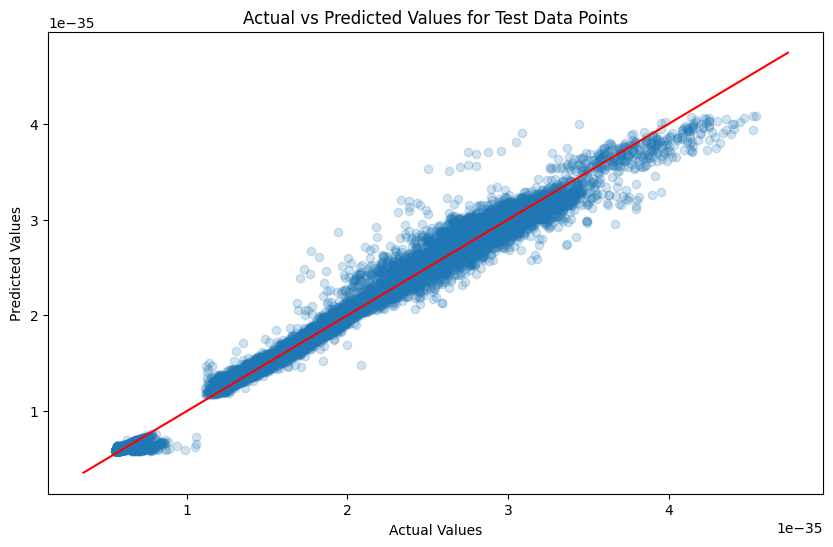

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, y_pred_test_orig, cmap='winter', alpha=0.2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
limits = [np.min([plt.xlim(), plt.ylim()]),  # find the lower limit
          np.max([plt.xlim(), plt.ylim()])]  # find the upper limit
plt.plot(limits, limits, color='red')
plt.title('Actual vs Predicted Values for Test Data Points')
plt.show()

In [41]:
def predict_ccs(mass, charge, sequence):
    model = tf.keras.models.load_model('LSTM_best_checkpoint.keras')

    with open('model_params.pkl', 'rb') as f:
        params = pickle.load(f)
    ccs_mean = params['mean']
    ccs_std = params['std']
    scaler = params['scaler']

    # Normalize the sequence
    sequence = normalize(sequence)

    length = len(sequence)
    mass_charge_scaled = scaler.transform(np.array([[mass, charge, length]]))
    
    sequence_encoded = one_hot_encode(sequence.ljust(encode_length, 'X'))

    ccs_z_pred = model.predict([np.array([sequence_encoded]), mass_charge_scaled])

    ccs_pred = ccs_z_pred * ccs_std + ccs_mean

    return ccs_pred[0][0]


# Test the function with some input values
mass = 4401.10689  
charge = 4   
sequence = 'AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGPGAVGER'  

predicted_ccs = predict_ccs(mass, charge, sequence)
print(f"Predicted CCS: {predicted_ccs}")
print("Actual: " + "2.65404611080076E-35")


1/1 [==============================] - 2s 2s/step
Predicted CCS: 2.4027586667162386e-35
Actual: 2.65404611080076E-35
